In [1]:
import os
import pandas as pd
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import os
import re
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly as py
import plotly.graph_objs as go
import gensim
from gensim import corpora, models, similarities
import logging
import tempfile
import nltk
nltk.download('stopwords')
from string import punctuation
from collections import OrderedDict
import seaborn as sns
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import json
from pandas.io.json import json_normalize
import random
from Data_Processor import Data_Processor

init_notebook_mode(connected=True) #do not miss this line
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yunzehui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yunzehui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yunzehui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yunzehui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [451]:
def datelist(start_month, end_month):
    start_year = int(start_month[:4])
    start_month = int(start_month[-2:])
    end_year = int(end_month[:4])
    end_month = int(end_month[-2:])
    if start_year == end_year:
        month_range = range(start_month, end_month + 1)
        date_list = ["{year}-{month:0=2d}".format(year=str(start_year), month=M) for M in month_range]
        return date_list
    year_range = range(start_year + 1, end_year)
    start_year_month_range = range(start_month, 13)
    end_year_month_range = range(1, end_month + 1)
    date_list = ["{year}-{month:0=2d}".format(year=str(start_year), month=M) for M in start_year_month_range]
    date_list += ["{year}-{month:0=2d}".format(year=str(Y), month=M) for Y in year_range for M in range(1, 13)]
    date_list += ["{year}-{month:0=2d}".format(year=str(end_year), month=M) for M in end_year_month_range]
    return date_list

def get_data(start_month, end_month, filepath, col):
    DP=Data_Processor(start_month, end_month, template=filepath)
    DP.readdata()

    dl = datelist(start_month, end_month)
    df = pd.DataFrame(columns=col)
    avgscores_month = pd.DataFrame(columns=('time', 'avg_positive_score', 'avg_negative_score'))
    scorespec_month = pd.DataFrame(columns=('time', 'positive1_pec', 'positive2_pec', 'positive3_pec',
                                            'positive4_pec','positive5_pec',
                                            'negative1_pec','negative2_pec','negative3_pec',
                                            'negative4_pec','negative5_pec'))
    labelpec_month = pd.DataFrame(columns=('time', 'Extremely Negative','Negative','Neutral','Positive', 'Extremely Positive'))
    
    for i in range(len(DP.data)):
        d = DP.data[i][:-1]

        # updating label
        # shoule be delated after we hava label in json
        for k in range(len(d)):
            if d[k]['positive'] >= -1.5*d[k]['negative']:
                if d[k]['positive']>=4:
                    d[k]['label']='Extremely Positive'
                else:
                    d[k]['label']='Positive'
            elif -1*d[k]['negative'] >= 1.5*d[k]['positive']:
                if -1*d[k]['negative']>=4:
                    d[k]['label']='Extremely Negative'
                else:
                    d[k]['label']='Negative'
            else:
                d[k]['label']='Neutral'

        d = pd.DataFrame(d,columns=col)
        df = df.append(d)
        
        pos = d['positive'].value_counts().to_frame()
        pos.columns = ["count"]
        pec_pos = pos['count'].values/sum(pos['count'].values)
        if len(pec_pos)<5:
            for i in range(len(pec_pos),5):
                pec_pos = np.append(pec_pos,0)
        neg = d['negative'].value_counts().to_frame()
        neg.columns = ["count"]
        pec_neg = neg['count'].values/sum(neg['count'].values)
        if len(pec_neg)<5:
            for i in range(len(pec_neg),5):
                pec_neg = np.append(pec_neg,0)
        
        label_pec = len(d[d['label']=='Positive'])/len(d)
        
        avgscores_month = avgscores_month.append(pd.DataFrame({'time':[dl[i]], 'avg_positive_score':[np.average(d['positive'])], 'avg_negative_score':[np.average(d['negative'])]}),ignore_index=True)
        scorespec_month = scorespec_month.append(pd.DataFrame({'time':[dl[i]], 
                                                               'positive1_pec':[pec_pos[0]], 
                                                               'positive2_pec':[pec_pos[1]], 
                                                               'positive3_pec':[pec_pos[2]],
                                                               'positive4_pec':[pec_pos[3]],
                                                               'positive5_pec':[pec_pos[4]],
                                                               'negative1_pec':[pec_neg[0]],
                                                               'negative2_pec':[pec_neg[1]],
                                                               'negative3_pec':[pec_neg[2]],
                                                               'negative4_pec':[pec_neg[3]],
                                                               'negative5_pec':[pec_neg[4]]}),ignore_index=True)
        
        labelpec_month = labelpec_month.append(pd.DataFrame({'time':[dl[i]], 
                                                             'Extremely Negative':[len(d[d['label']=='Extremely Negative'])/len(d)],
                                                             'Negative':[len(d[d['label']=='Negative'])/len(d)],
                                                             'Neutral':[len(d[d['label']=='Neutral'])/len(d)],
                                                             'Positive':[len(d[d['label']=='Positive'])/len(d)], 
                                                             'Extremely Positive':[len(d[d['label']=='Extremely Positive'])/len(d)]}),ignore_index=True)
                                                             

                                                               
    return df, avgscores_month, scorespec_month, labelpec_month

In [528]:
# Visualization Function
def show_percentage(label, colors):
    score_dist = label.value_counts().to_frame()
    score_dist.columns = ["count"]
    score_dist = score_dist.reset_index().sort_values(by = "index" ,ascending = False)

    layout = go.Layout(dict(title = "Scores distribution",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         gridwidth = 2),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         gridwidth = 2),
                            )
                      )

    trace = go.Bar(x = score_dist["index"],
                   y = score_dist["count"],
                   marker = dict(line = dict(width = 1,color = "black"),
                                 color = "gold")
                  )


    fig = go.Figure(data = [trace],layout = layout)
    py.offline.iplot(fig)
    
    labels = list(score_dist['index'].values)
    sizes = list(score_dist['count'].values/sum(score_dist['count'].values)*100)
    #explode = (0.1, 0, 0)
    fig1, ax1 = plt.subplots(figsize=(8,8))
    ax1.pie(sizes, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal') 
    plt.legend(labels, loc='upper right')
    plt.show()
    return score_dist
    
def avgscore_trend(avgscores_month, start_month, end_month):
    fig, axs = plt.subplots(2,sharex=True,figsize=(16,8))
    fig.suptitle('Trends of Sentiment (Average Score in Each Month)', fontsize=15)
    axs[0].plot(avgscores_month['avg_positive_score'],label='positive')
    axs[1].plot(avgscores_month['avg_negative_score'],label='negative',color='orange')
    dl = datelist(start_month, end_month)
    plt.xticks(range(0,len(dl)), dl)
    plt.tick_params(axis='x', labelsize=8) 
    plt.xticks(rotation=45) 
    axs[0].legend(loc='upper right')
    axs[1].legend(loc='upper right')
    plt.show

In [529]:
def scorepec_trend(scorespec_month, start_month, end_month):
    fig, axs = plt.subplots(2,sharex=True,figsize=(16,16))
    fig.suptitle('Trends of Sentiment (Percentage of Sentiment Scores in Each Month)', fontsize=15)
    axs[0].plot(scorespec_month['positive1_pec'],label='positive 1')
    axs[0].plot(scorespec_month['positive2_pec'],label='positive 2')
    axs[0].plot(scorespec_month['positive3_pec'],label='positive 3')
    axs[0].plot(scorespec_month['positive4_pec'],label='positive 4')
    axs[0].plot(scorespec_month['positive5_pec'],label='positive 5')
    
    axs[1].plot(scorespec_month['negative1_pec'],label='negative -1')
    axs[1].plot(scorespec_month['negative2_pec'],label='negative -2')
    axs[1].plot(scorespec_month['negative3_pec'],label='negative -3')
    axs[1].plot(scorespec_month['negative4_pec'],label='negative -4')
    axs[1].plot(scorespec_month['negative5_pec'],label='negative -5')
    dl = datelist(start_month, end_month)
    plt.xticks(range(0,len(dl)), dl)
    plt.tick_params(axis='x', labelsize=8) 
    plt.xticks(rotation=45) 
    axs[0].legend(loc='upper right')
    axs[1].legend(loc='upper right')
    plt.show
    
def labelpec_trend1(labelpec_month, start_month, end_month):
    plt.figure(figsize=(16,8))
    plt.title('Trends of Sentiment (Percentage of labels in Each Month)', fontsize=15)
    plt.plot(labelpec_month['Extremely Negative'],label='Extremely Negative')
    plt.plot(labelpec_month['Negative'],label='Negative')
    plt.plot(labelpec_month['Neutral'],label='Neutral')
    plt.plot(labelpec_month['Positive'],label='Positive')
    plt.plot(labelpec_month['Extremely Positive'],label='Extremely Positive')
    dl = datelist(start_month, end_month)
    plt.xticks(range(0,len(dl)), dl)
    plt.tick_params(axis='x', labelsize=8) 
    plt.xticks(rotation=45) 
    plt.legend(loc='upper right')
    plt.show

def labelpec_trend2(labelpec_month, start_month, end_month):
    plt.figure(figsize=(16,8))
    plt.title('Trends of Sentiment (Percentage of labels in Each Month)', fontsize=15)
    plt.plot(labelpec_month['Extremely Negative']+labelpec_month['Negative'],label='Negative')
    plt.plot(labelpec_month['Neutral'],label='Neutral')
    plt.plot(labelpec_month['Positive']+labelpec_month['Extremely Positive'],label='Positive')
    dl = datelist(start_month, end_month)
    plt.xticks(range(0,len(dl)), dl)
    plt.tick_params(axis='x', labelsize=8) 
    plt.xticks(rotation=45) 
    plt.legend(loc='upper right')
    plt.show

In [530]:
def avgscore_trend_comparasion(com_list, com_name, start_month, end_month):
    fig, axs = plt.subplots(2,sharex=True,figsize=(16,8))
    fig.suptitle('Comparation of Trends of Sentiment (Average Score in Each Month)')
    for i in range(len(com_list)-1):
        axs[0].plot(com_list[i]['avg_positive_score'], label = com_name[i])
        axs[1].plot(com_list[i]['avg_negative_score'], label = com_name[i])
    
    # Plot Overall
    axs[0].plot(com_list[i+1]['avg_positive_score'], label = com_name[i+1], linewidth=4)
    axs[1].plot(com_list[i+1]['avg_negative_score'], label = com_name[i+1], linewidth=4)
    
    dl = datelist(start_month, end_month)
    plt.xticks(range(0,len(dl)), dl)
    plt.tick_params(axis='x', labelsize=8) 
    plt.xticks(rotation=45) 
    axs[0].legend(loc='upper right')
    axs[1].legend(loc='upper right')
    plt.show

In [455]:
#col type of previous sentiment model
#col=['tweet_id','tweet_url','text','text_html','links','hashtags', 'img_urls','timestamp','timestamp_epochs','likes','replies','retweets','username','screen_name','user_id','is_reply_to','is_replied','reply_to_users','parent_tweet_id','has_media','label','score']

#col type of SentiStrength
col=['tweet_id','tweet_url','text','text_html','links','hashtags', 'img_urls','timestamp','timestamp_epochs','likes','replies','retweets','username','screen_name','user_id','is_reply_to','is_replied','reply_to_users','parent_tweet_id','has_media','positive','negative', 'label']
colors3 = ['gold','paleturquoise','lightskyblue']
colors5 = ['gold','paleturquoise','lightskyblue','pink','wheat']

# Discount Brokerage

### Charles Schwab

In [468]:
start_month='2017-06'
end_month='2020-05'
filepath = ["SentiStrength/Discount Brokerage/Charles Schwab/CharlesSchwab"]

In [469]:
data_charles, avgscores_month_charles, scorespec_month_charles, labelpec_month_charles = get_data(start_month, end_month, filepath, col)

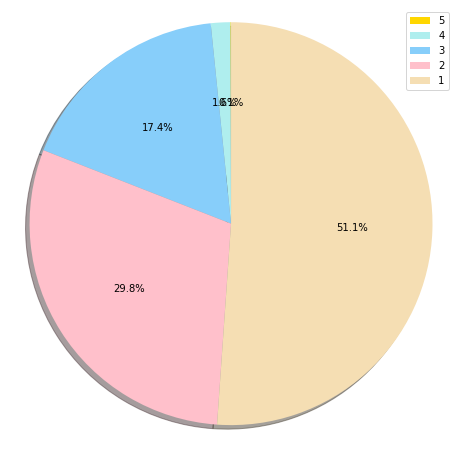

In [531]:
score_dist_charles_pos = show_percentage(data['positive'], colors5)

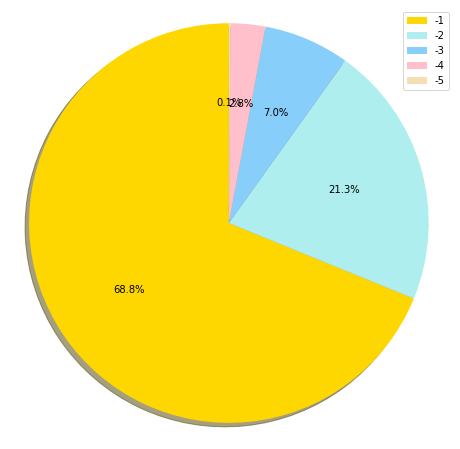

In [532]:
score_dist_charles_neg = show_percentage(data['negative'], colors5)

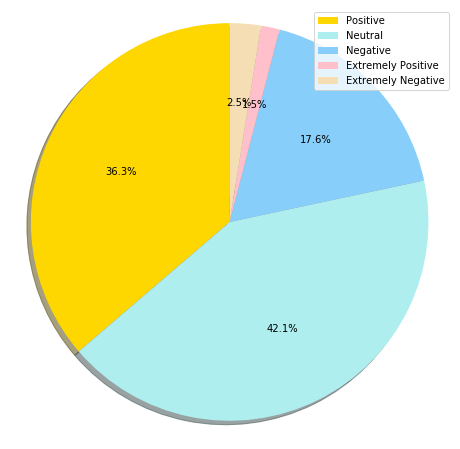

In [533]:
score_dist_charles = show_percentage(data['label'], colors5)

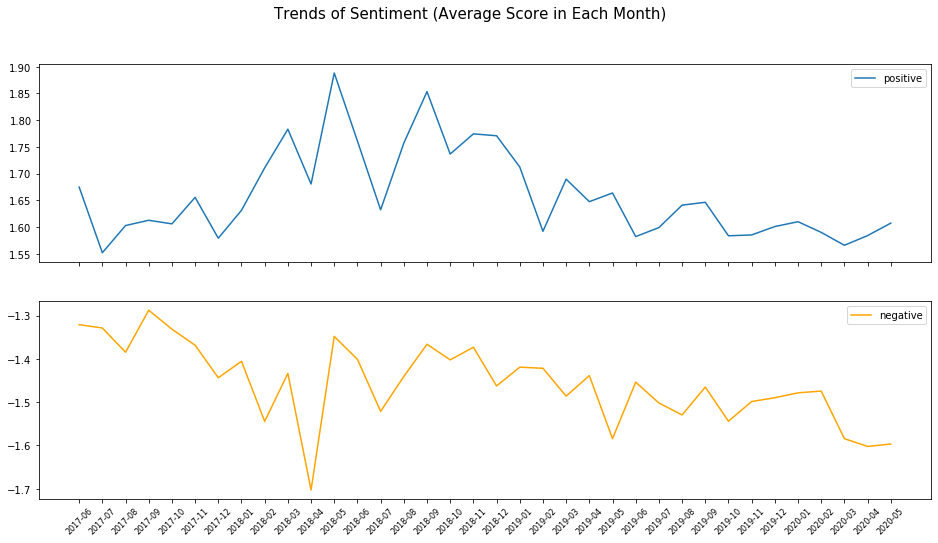

In [539]:
avgscore_trend(avgscores_month_charles, start_month, end_month)

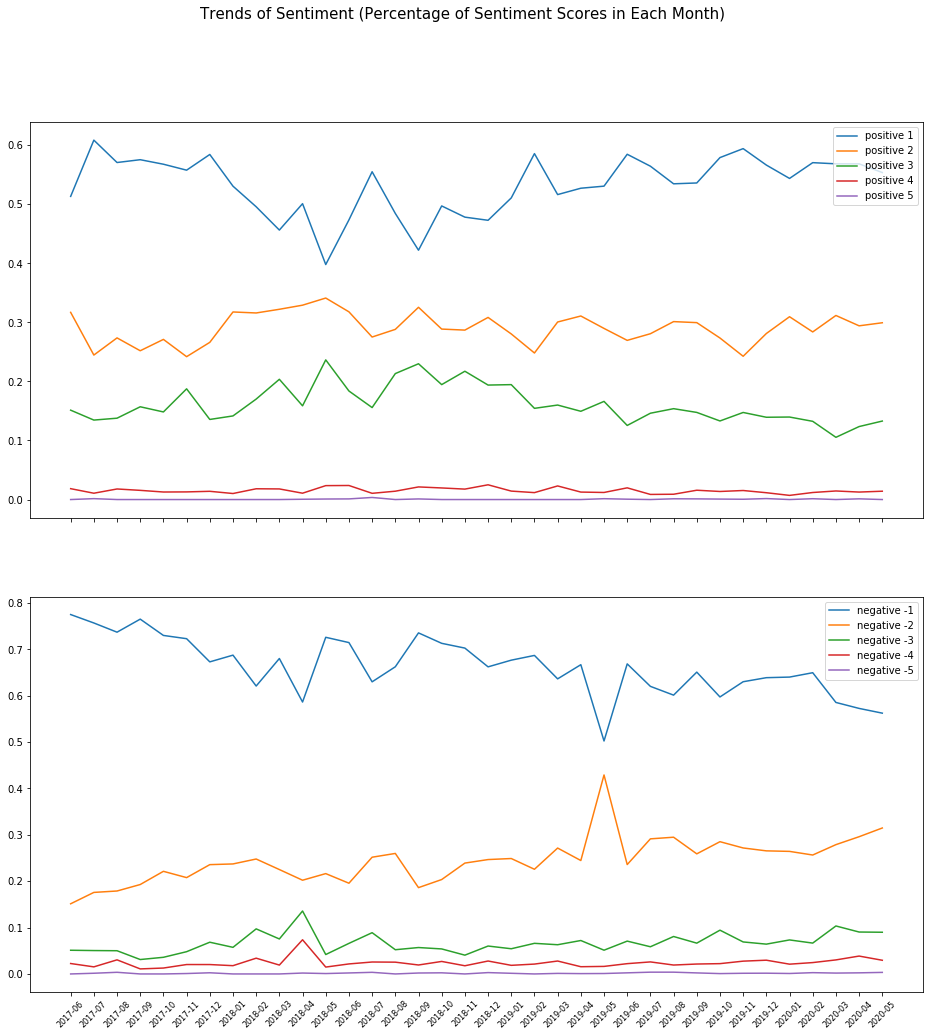

In [540]:
scorepec_trend(scorespec_month_charles, start_month, end_month)

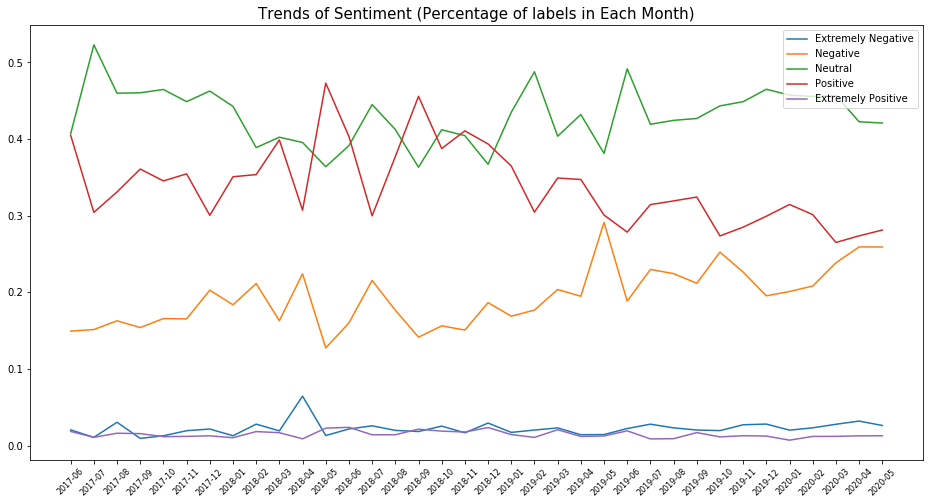

In [541]:
labelpec_trend1(labelpec_month_charles, start_month, end_month)

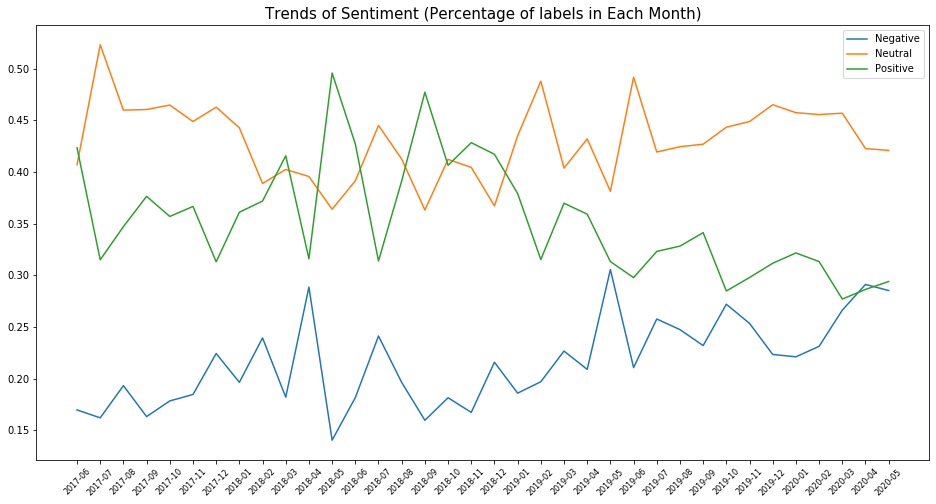

In [542]:
labelpec_trend2(labelpec_month_charles, start_month, end_month)

### Robinhood

In [477]:
start_month='2017-06'
end_month='2020-05'
filepath = ["SentiStrength/Discount Brokerage/Robinhood/Robinhood"]

In [478]:
data_robin, avgscores_month_robin, scorespec_month_robin, labelpec_month_robin = get_data(start_month, end_month, filepath, col)

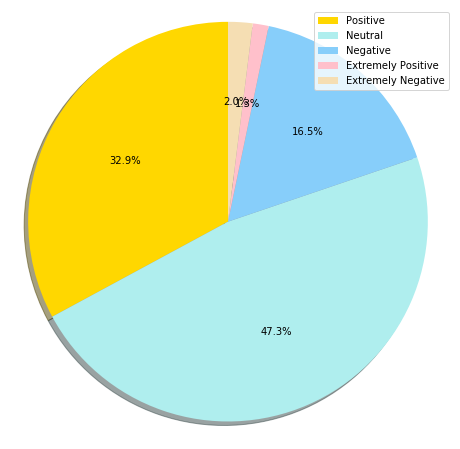

In [479]:
score_dist_charles = show_percentage(data_robin['label'], colors5)

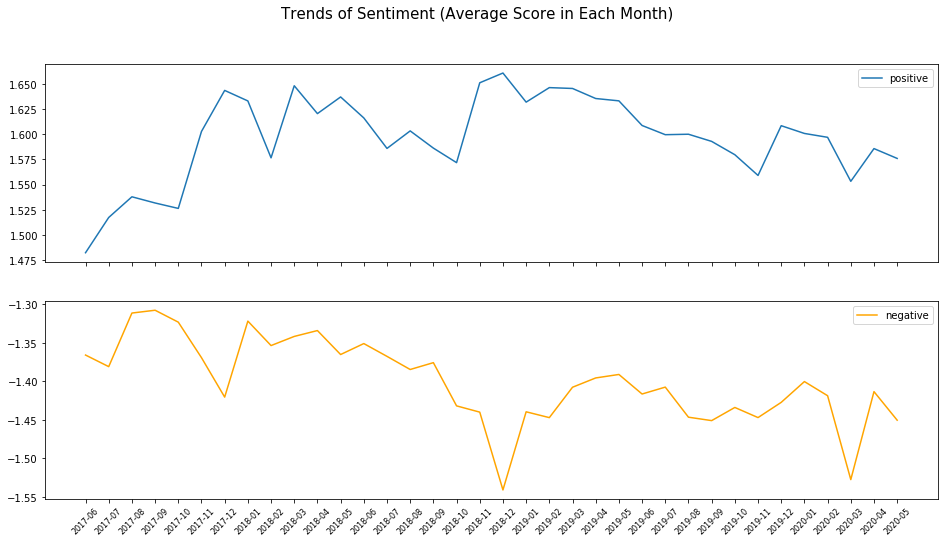

In [543]:
avgscore_trend(avgscores_month_robin, start_month, end_month)

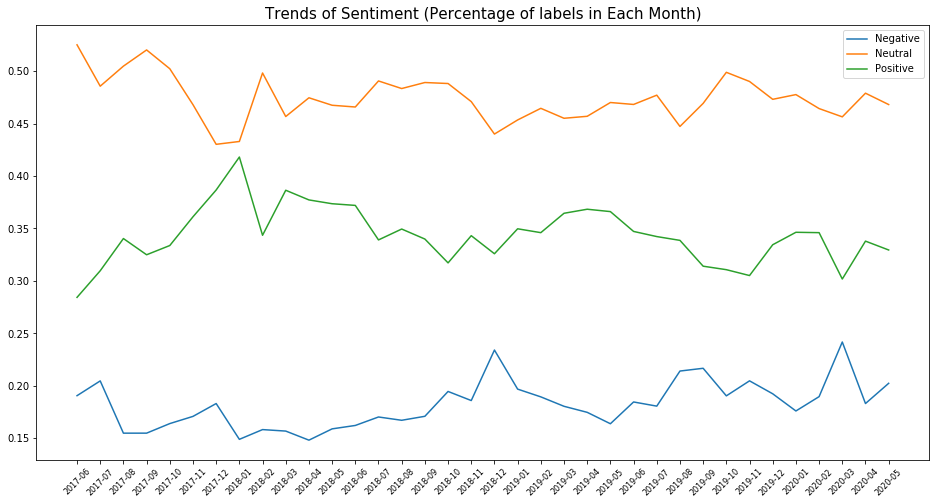

In [544]:
labelpec_trend2(labelpec_month_robin, start_month, end_month)

## Overall

In [488]:
start_month='2017-06'
end_month='2018-03'
filepath = ["SentiStrength/Discount Brokerage/Charles Schwab/CharlesSchwab", "SentiStrength/Discount Brokerage/Robinhood/Robinhood"]

In [489]:
data_db, avgscores_month_db, scorespec_month_db, labelpec_month_db = get_data(start_month, end_month, filepath, col)

## Comparasion

In [546]:
com_list=[avgscores_month_charles, avgscores_month_robin, avgscores_month_db]
com_name=['Charles Schwab', 'Robinhood', 'Discount brokerage']

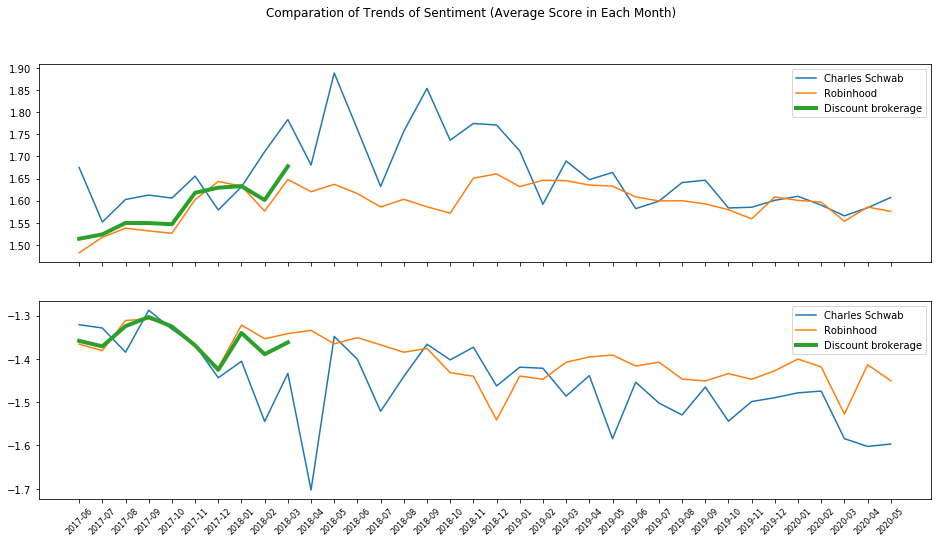

In [547]:
avgscore_trend_comparasion(com_list, com_name, start_month, end_month)

# Full Brokerage

### Goldman_Sachs

In [492]:
start_month='2017-06'
end_month='2020-05'
filepath = ["SentiStrength/Full Brokerage/Goldman_Sachs/Goldman_Sachs"]

In [493]:
data_Goldman_Sachs, avgscores_month_Goldman_Sachs, scorespec_month_Goldman_Sachs, labelpec_month_Goldman_Sachs = get_data(start_month, end_month, filepath, col)

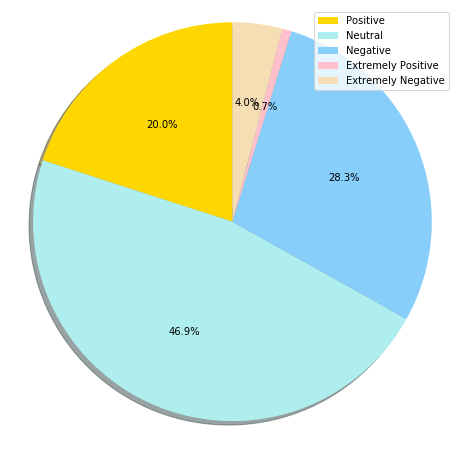

In [494]:
score_dist_Goldman_Sachs = show_percentage(data_Goldman_Sachs['label'], colors5)

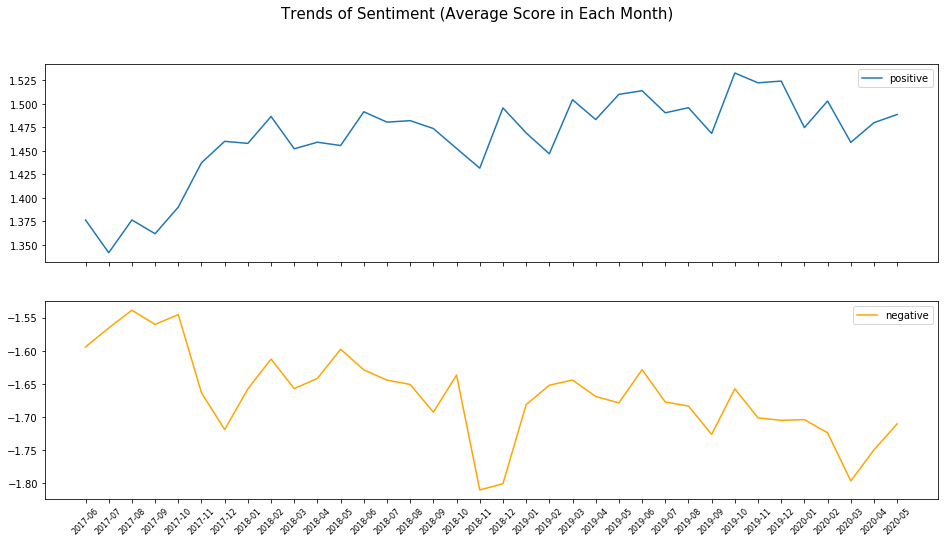

In [548]:
avgscore_trend(avgscores_month_Goldman_Sachs, start_month, end_month)

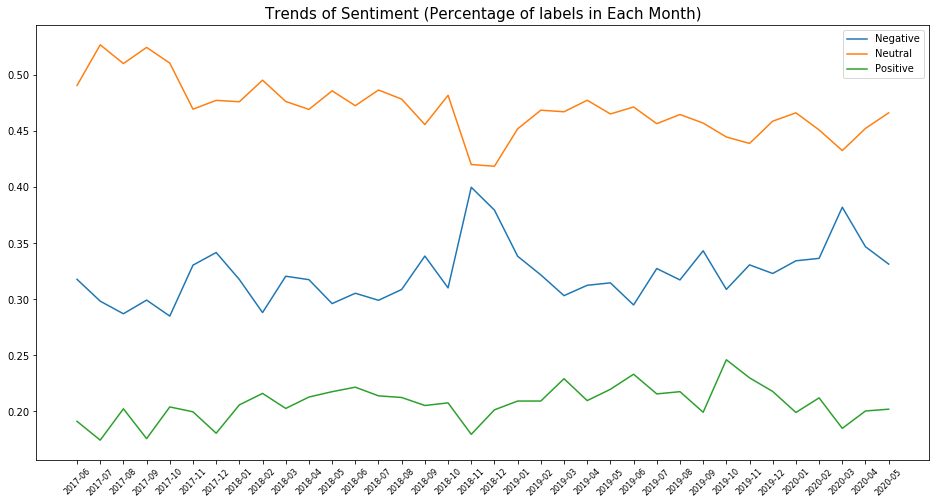

In [549]:
labelpec_trend2(labelpec_month_Goldman_Sachs, start_month, end_month)

### Morgan_Stanley

In [502]:
start_month='2017-06'
end_month='2020-05'
filepath = ["SentiStrength/Full Brokerage/Morgan_Stanley/Morgan_Stanley"]

In [503]:
data_Morgan_Stanley, avgscores_month_Morgan_Stanley, scorespec_month_Morgan_Stanley, labelpec_month_Morgan_Stanley = get_data(start_month, end_month, filepath, col)

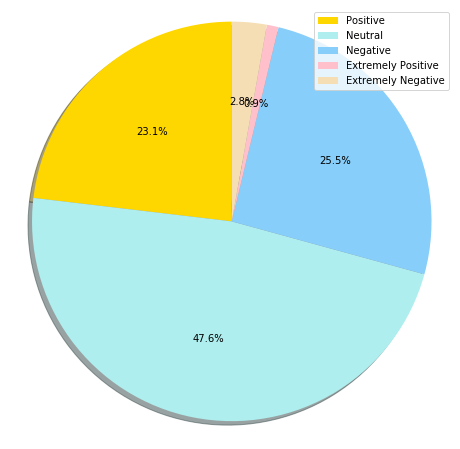

In [504]:
score_dist_Morgan_Stanley = show_percentage(data_Morgan_Stanley['label'], colors5)

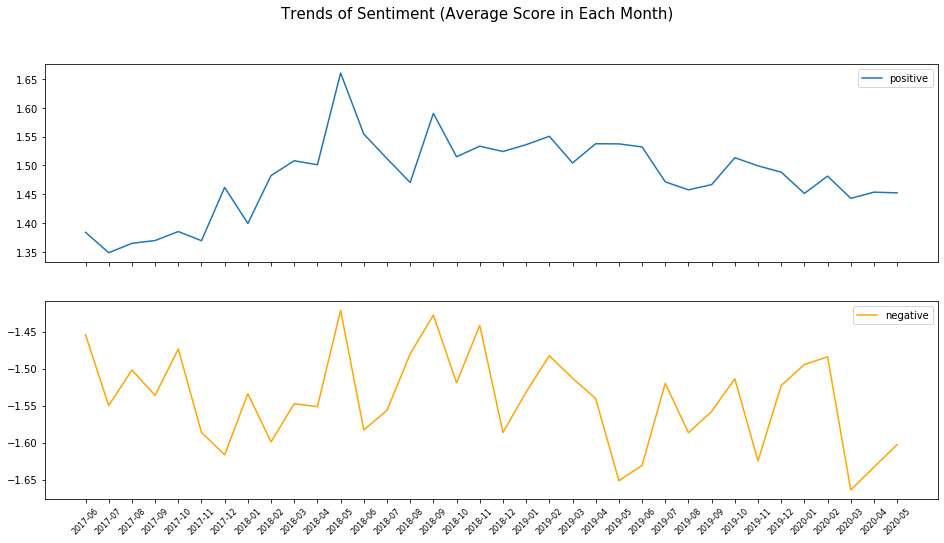

In [550]:
avgscore_trend(avgscores_month_Morgan_Stanley, start_month, end_month)

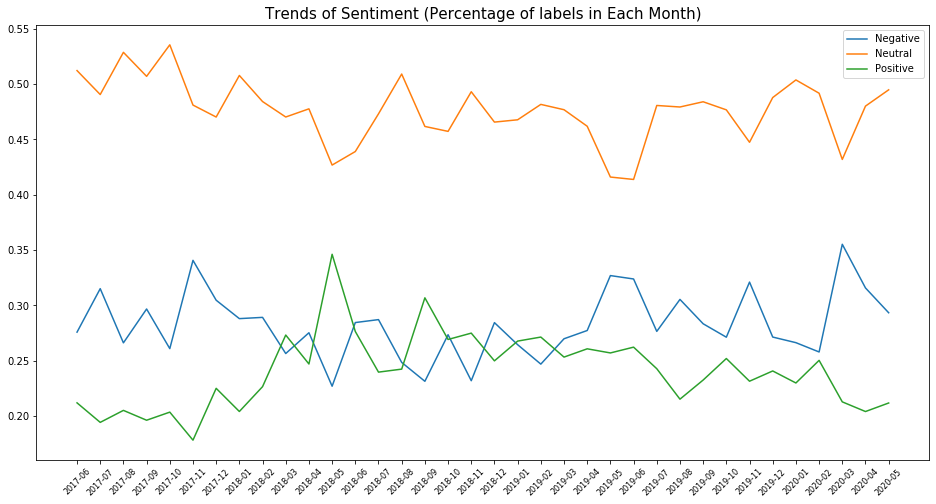

In [551]:
labelpec_trend2(labelpec_month_Morgan_Stanley, start_month, end_month)

### UBS

In [507]:
start_month='2017-06'
end_month='2020-05'
filepath = ["SentiStrength/Full Brokerage/UBS/UBS"]

In [508]:
data_UBS, avgscores_month_UBS, scorespec_month_UBS, labelpec_month_UBS = get_data(start_month, end_month, filepath, col)

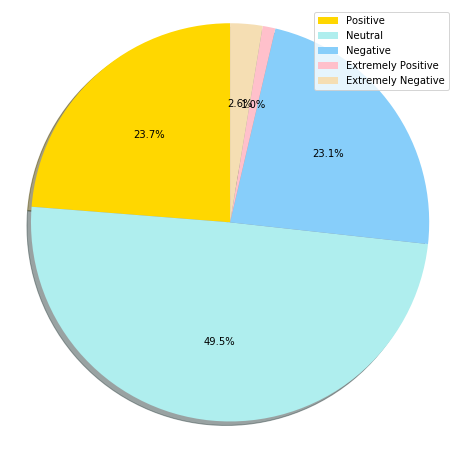

In [509]:
score_dist_UBS = show_percentage(data_UBS['label'], colors5)

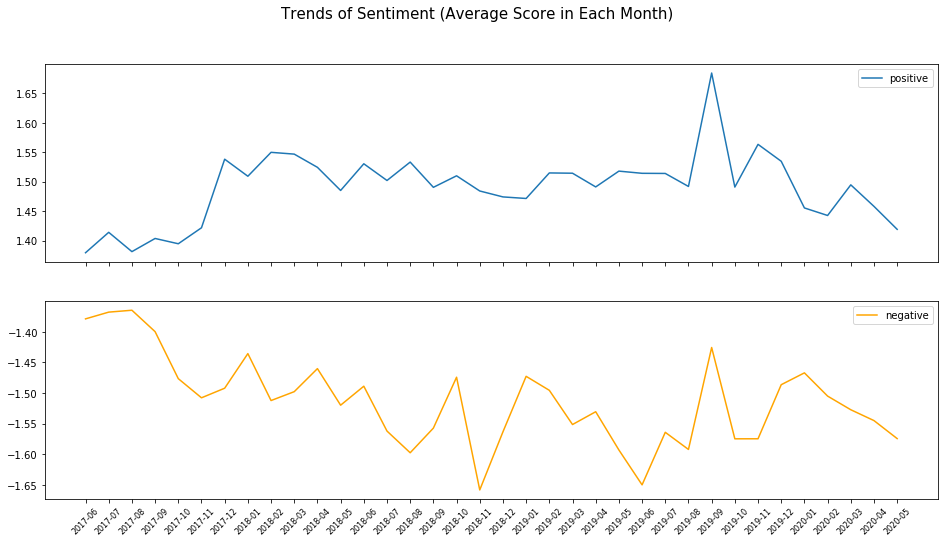

In [552]:
avgscore_trend(avgscores_month_UBS, start_month, end_month)

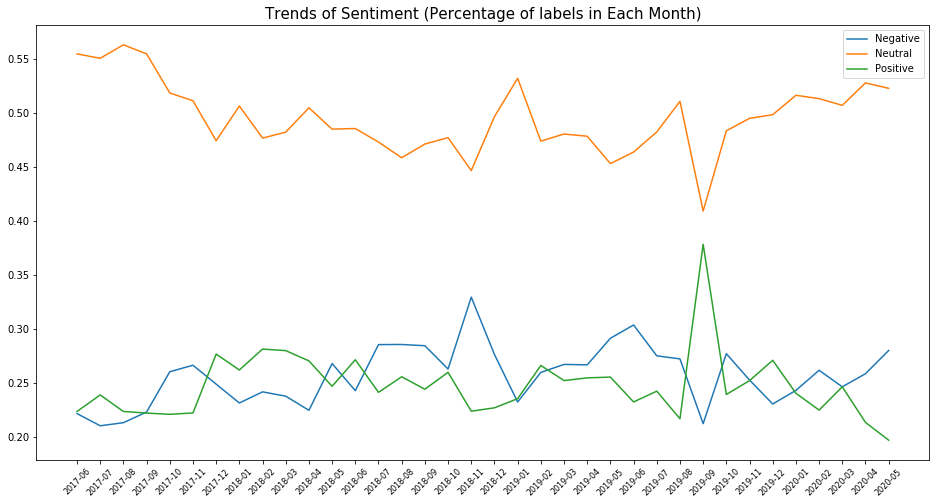

In [553]:
labelpec_trend2(labelpec_month_UBS, start_month, end_month)

## Overall

In [565]:
start_month='2017-06'
end_month='2020-05'
filepath = ["SentiStrength/Full Brokerage/Goldman_Sachs/Goldman_Sachs", 
            "SentiStrength/Full Brokerage/Morgan_Stanley/Morgan_Stanley",
            "SentiStrength/Full Brokerage/UBS/UBS"]

In [566]:
data_fb, avgscores_month_fb, scorespec_month_fb, labelpec_month_fb = get_data(start_month, end_month, filepath, col)

KeyError: 'positive'

## Comparasion

In [555]:
com_list=[avgscores_month_Goldman_Sachs, avgscores_month_Morgan_Stanley, avgscores_month_UBS, avgscores_month_fb]
com_name=['Goldman_Sachs', 'Morgan_Stanley', "UBS", 'Full Brokerage']

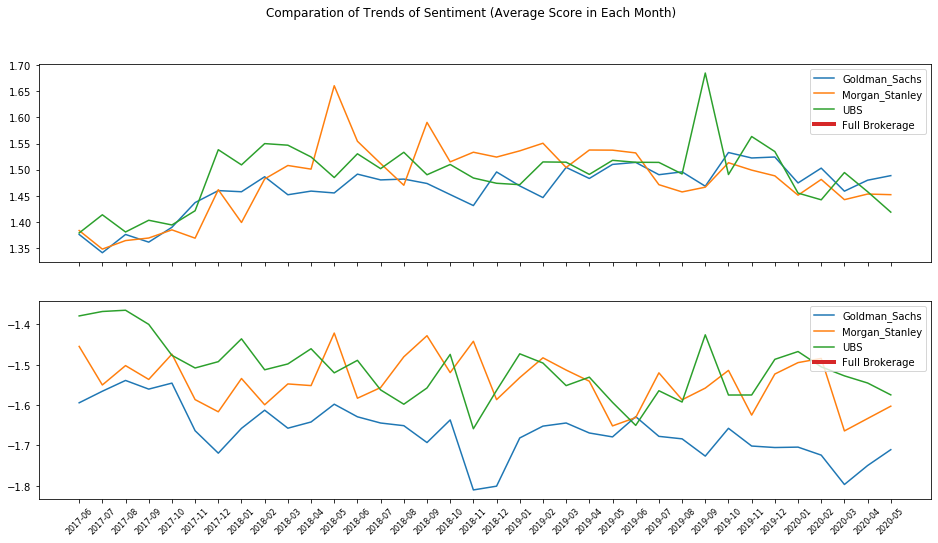

In [556]:
avgscore_trend_comparasion(com_list, com_name, start_month, end_month)

# Bank Brokerage

### JPMorgan

In [573]:
start_month='2017-06'
end_month='2020-05'
filepath = ["SentiStrength/Bank Brokerage/JPMorgan/JPMorgan"]

In [574]:
data_JPMorgan, avgscores_month_JPMorgan, scorespec_month_JPMorgan, labelpec_month_JPMorgan = get_data(start_month, end_month, filepath, col)

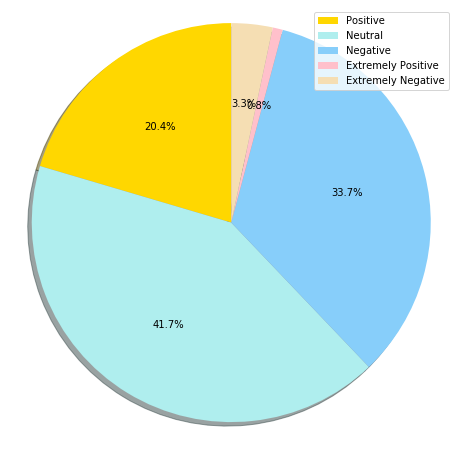

In [575]:
score_dist_JPMorgan = show_percentage(data_JPMorgan['label'], colors5)

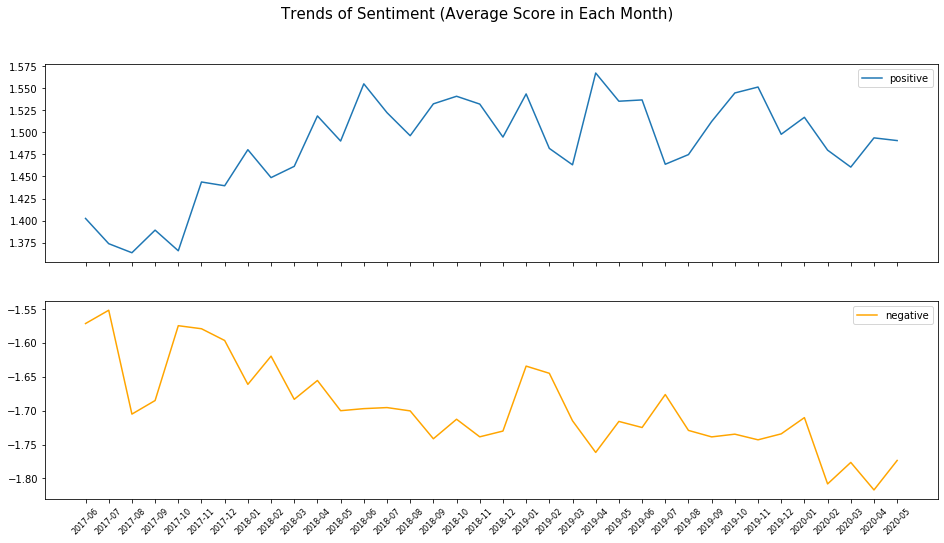

In [576]:
avgscore_trend(avgscores_month_JPMorgan, start_month, end_month)

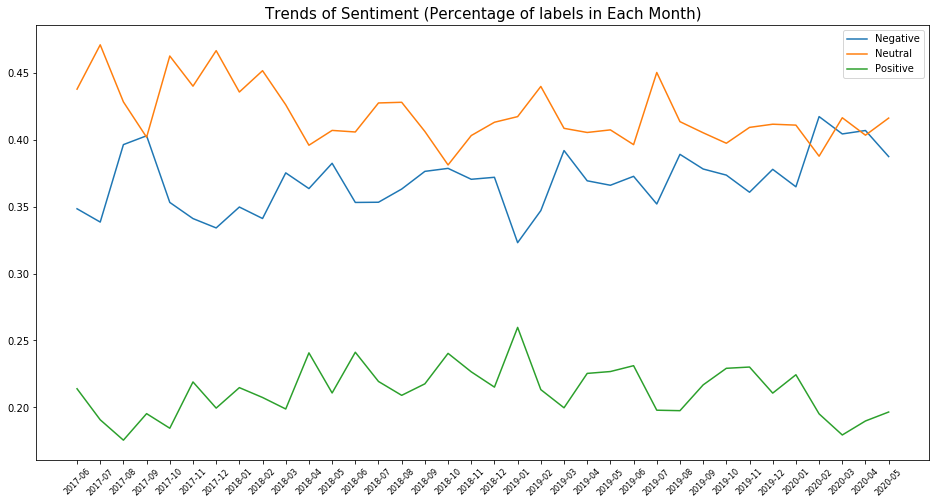

In [577]:
labelpec_trend2(labelpec_month_JPMorgan, start_month, end_month)

## Overall

In [571]:
start_month='2017-06'
end_month='2020-05'
filepath = ["SentiStrength/Bank Brokerage/BOA/BankofAmerica", 
            "SentiStrength/Bank Brokerage/JPMorgan/JPMorgan",
            "SentiStrength/Bank Brokerage/Merrill Lynch/MerrillLynch", 
            "SentiStrength/Bank Brokerage/Wells Fargo/WellsFargo"]

In [572]:
data_bb, avgscores_month_bb, scorespec_month_bb, labelpec_month_bb = get_data(start_month, end_month, filepath, col)

KeyError: 'positive'